# Simulating forced choice tasks in ExemPy

ExemPy is built to simulate the types of tasks that are often used in speech perception experiments. This allows us to more directly 

In ExemPy-Basics, we simulated an identifcation task, in which the "perceiver" provides a label from multiple options. This allowed us to produce a confusion matrix. 

Simulating a two-alternative forced choice (2AFC) task allows us to produce the type of plot often used to demonstrate categorical perception. 

In [1]:
%load_ext autoreload
from ExemPy import *
from ExemPy.utils import *
from ExemPy.viz import *
from ExemPy.GCM import *
%aimport ExemPy, ExemPy.utils, ExemPy.viz, ExemPy.GCM
%autoreload 1
import math
import random
import matplotlib.pyplot as plt
#%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
from scipy.optimize import minimize
import seaborn as sns
sns.set(style='ticks', context='paper')
colors=["#e3c934","#68c4bf","#c51000","#287271"]
sns.set_palette(colors)

## Set up data
- Read in Peterson and Barney 1952
- Convert Hz to Bark
- Preview pb52

In [2]:
pb52 = pd.read_csv('pb52_data//pb52.csv')
pb52 = HzToBark(pb52,["F0", "F1", "F2", "F3"])
pb52.sample(5)

,type,gender,speaker,vowel,repetition,F0,F1,F2,F3,z0,z1,z2,z3
224,m,m,12,DRESS,1,115,560,1650,2300,0.955855,5.427778,11.723878,13.944883
1185,w,f,60,DRESS,2,219,650,2430,3040,2.164534,6.146820,14.310159,15.770480
406,m,m,21,TRAP,1,138,620,1800,2440,1.233480,5.912713,12.304574,14.337364
1112,w,f,56,THOUGHT,1,229,688,1029,2750,2.274701,6.435740,8.699672,15.123397
633,m,m,32,THOUGHT,2,115,700,1000,2250,0.955855,6.525263,8.527432,13.798385


## Set parameters

In [3]:
dimsvals ={
    "z0": 1,
    "z1": 2.56,
    "z2": 1.985,
    "z3": 1.34 }
dimslist = list(dimsvals.keys())
catslist = ['type', 'vowel']           # man, woman, or child; lexical set notation
cval = 25

In [4]:
# Get average values for each type x vowel
###(Averages across speakers and repetitions)
datasumm = datasummary(pb52, catslist, dimslist)
print("Type 'w' formant averages (Bark) by vowel:")
datasumm[datasumm["type"]=="w"]

Type 'w' formant averages (Bark) by vowel:


,type,vowel,z0,z1,z2,z3
20,w,DRESS,2.173631,5.801199,14.028881,15.674275
21,w,FLEECE,2.292515,3.125540,15.191459,16.292670
22,w,FOOT,2.323410,4.636707,9.405672,14.947067
23,w,GOOSE,2.333479,3.794188,8.226731,14.899569
24,w,KIT,2.306120,4.386027,14.414048,15.809872
25,w,NURSE,2.165065,4.929947,11.648995,12.887087
26,w,PALM,2.078013,7.652141,9.785481,15.179671
27,w,STRUT,2.200470,6.936452,10.662141,15.151736
28,w,THOUGHT,2.133781,5.622050,7.966429,15.062146
29,w,TRAP,2.040201,7.632623,13.145777,15.300653


## Create interpolated continuum from 1 row to another

In [5]:
start = {"type" : "w", "vowel" : "FOOT"}      # Step 1
end = {"type" : "w", "vowel" : "STRUT"}         # Step n
terms = {"vowel" : ["FOOT", "STRUT"]}        # Two alternatives
steps = 7                                 # Number of steps in continuum

cont = continuum(datasumm, start, end, dimslist, steps, stimdetails = True)
cont

Start:  index           22
type             w
vowel         FOOT
z0         2.32341
z1        4.636707
z2        9.405672
z3       14.947067
Name: 0, dtype: object
End:  index           27
type             w
vowel        STRUT
z0         2.20047
z1        6.936452
z2       10.662141
z3       15.151736
Name: 0, dtype: object


,step,z0,z1,z2,z3
0,1,2.32341,4.636707,9.405672,14.947067
1,2,2.30292,5.019998,9.615083,14.981178
2,3,2.28243,5.403288,9.824495,15.015290
3,4,2.26194,5.786579,10.033906,15.049401
4,5,2.24145,6.169870,10.243318,15.083513
5,6,2.22096,6.553161,10.452729,15.117624
6,7,2.20047,6.936452,10.662141,15.151736


## Categorize continuum with respect to pb52 

NOTE: There is a problem here that needs to be addressed. The fundamental question is "When does "forced choice" happen?" This is probably on some level a theoretical question, but immediately it's a methodological challenge. 

The problem is relevant for the cpplot() function, but it may need to be addressed upstream in the choose() function... which in turn may need to be addressed in the prob() function, and it may in fact go all the way up to the calculation of activation. It may very well be the case that when categorization is operating under "forced choice" circumstances *N* of all non-option exemplars is significantly lowered. This would mean that they can't contribute as much activation, and therefore. This will be explored further in the "expectations" notebook.

Methodologically, what I did do is
- During choose()
    - Keep the actual probability of categorization
    - Choose the higher of the two 
- In the cpplot() <br>
    - if vowel choice is A, y = probability of vowel choice being A
    - if vowel choice is not A, y = 1- probability of vowel choice
    
This works if A and B are the only two things chosen (and B is the runnerup to A). This is not the case with w-3 below. If we turn fc off and allow choose() to pick the vowel with the overall highest probability, it's actually PALM. 

So what do we do for y when the choice is neither A nor B, but C? To plot the probability of A implies a potentially quite high probability of B, which isn't the case. The choose function is behaving as expected when given the forced choice terms, choosing the alternative of the two with the higher probability. It doesn't change the probability of the choice. 

How do we show that stimulus 3 is less likely to be FOOT than stimulus 2, but still not likely to be STRUT? Does it matter anywhere other than this specific plot? 

This makes the analysis of the curves below kind of irrelevant, but I'm not ready to delete that paragraph yet so they are there for safe-keeping! 

In [7]:
dimsvals = {'z0' : 1,
            'z1' : .761,
            'z2' : .681,
            'z3' : .407}
dimslist = list(dimsvals.keys())
catslist = ['type','vowel']           # man, woman, or child; lexical set notation
cval = 25

excloud = pb52.copy()


terms = {"vowel" : ["FOOT", "STRUT"]}

In [8]:
# forced coice on

choices_cont = multicat(cont, excloud.copy(), catslist, dimsvals, cval, exclude_self = True, N = 1, fc = terms)
choices_cont

,step,z0,z1,z2,z3,typeChoice,typeProb,vowelChoice,vowelProb
0,1,2.32341,4.636707,9.405672,14.947067,w,0.958173,FOOT,0.974100
1,2,2.30292,5.019998,9.615083,14.981178,w,0.977810,FOOT,0.992542
2,3,2.28243,5.403288,9.824495,15.015290,w,0.980696,FOOT,0.607590
3,4,2.26194,5.786579,10.033906,15.049401,w,0.960333,FOOT,0.280120
4,5,2.24145,6.169870,10.243318,15.083513,w,0.961737,STRUT,0.767191
5,6,2.22096,6.553161,10.452729,15.117624,w,0.990411,STRUT,0.994830
6,7,2.20047,6.936452,10.662141,15.151736,w,0.983766,STRUT,0.994342


In [9]:
# forced choice off

choices_cont = multicat(cont, excloud.copy(), catslist, dimsvals, cval, exclude_self = True, N = 1)
choices_cont

,step,z0,z1,z2,z3,typeChoice,typeProb,vowelChoice,vowelProb
0,1,2.32341,4.636707,9.405672,14.947067,w,0.958173,FOOT,0.974100
1,2,2.30292,5.019998,9.615083,14.981178,w,0.977810,FOOT,0.992542
2,3,2.28243,5.403288,9.824495,15.015290,w,0.980696,FOOT,0.607590
3,4,2.26194,5.786579,10.033906,15.049401,w,0.960333,PALM,0.624499
4,5,2.24145,6.169870,10.243318,15.083513,w,0.961737,STRUT,0.767191
5,6,2.22096,6.553161,10.452729,15.117624,w,0.990411,STRUT,0.994830
6,7,2.20047,6.936452,10.662141,15.151736,w,0.983766,STRUT,0.994342


### Categorical perception plot

The plot below shows the results of our simulated 2AFC identification task. On the X-axis is the continuum from FOOT (step 1) to STRUT (step 7). On the Y-axis is the probability of categorization as FOOT (rather than STRUT), which is taken as analagous to the proportion of FOOT responses in an experiment. 

A dotted line is printed at 0.5, or roughly chance. Above this line, "FOOT" is a more likely response than "STRUT". We can consider the point along the continuum at which the curve crosses this line as the boundary between "FOOT" and "STRUT".

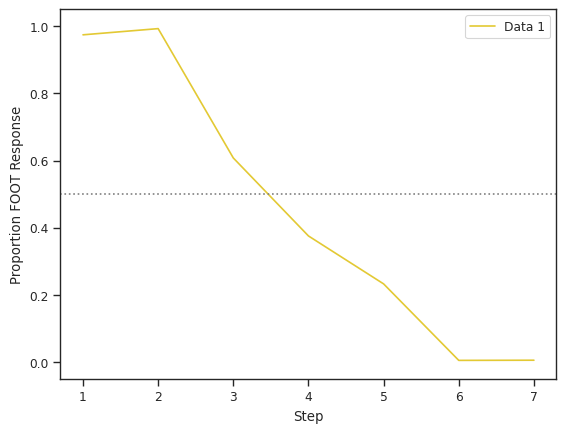

In [10]:
cpplot(choices_cont, "vowel")

## Repeat this process with average man and child values

When the "perceiver" is "presented" with different stimuli, the curves differ in two ways:
- <b> Boundary. </b> 
    - The point at which STRUT becomes more likely than FOOT is stimulus 4 for w and c, but 5 for m
    - This means that for the m continuum, the listener will accept a more centralized vowel as FOOT than they will with the w or c 
- <b> Shape. </b>
    - All of the curves show some degree of plateauing at the ends, corresponding to the very clear FOOT and STRUT ends of the continuum, as expected. The most clear examples have equally comparably extreme probabilities
    - The shape of the w curve is more linear than that of c and m. This means that for the w continuum, STRUT is still somewhat likely in the middle of the continuum
    - c and m both have long plateaus on the STRUT end of the continuum, meaning that once the boundary has been crossed, STRUT is more or less equally likely, regardless of the specific step
    - On the FOOT end of the continuum, however, c patterns more similarly to w. 

In [11]:
continuum_is = {"vowel" : ["FOOT", "STRUT"]}
grouping = {"type" : ["w", "c", "m"]}
steps = 7
dimsvals = {'z0' : 1,
            'z1' : .761,
            'z2' : .681,
            'z3' : .407}
dimslist = list(dimsvals.keys())
catslist = ['vowel']           # man, woman, or child; lexical set notation
cval = 25

excloud = pb52.copy()

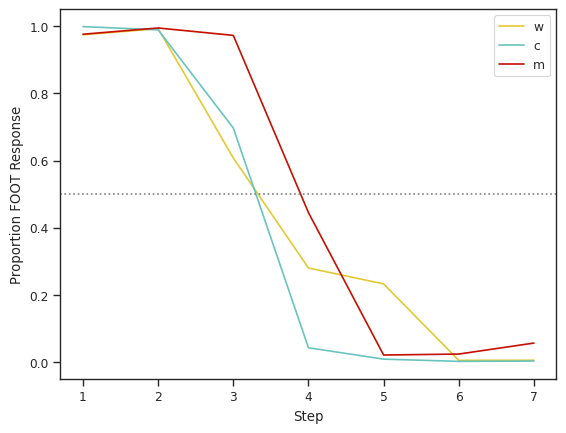

[   step       z0        z1         z2         z3 vowelChoice  vowelProb
0     1  2.32341  4.636707   9.405672  14.947067        FOOT   0.974100
1     2  2.30292  5.019998   9.615083  14.981178        FOOT   0.992542
2     3  2.28243  5.403288   9.824495  15.015290        FOOT   0.607590
3     4  2.26194  5.786579  10.033906  15.049401        FOOT   0.280120
4     5  2.24145  6.169870  10.243318  15.083513       STRUT   0.767191
5     6  2.22096  6.553161  10.452729  15.117624       STRUT   0.994830
6     7  2.20047  6.936452  10.662141  15.151736       STRUT   0.994342,    step        z0        z1         z2         z3 vowelChoice  vowelProb
0     1  2.743536  5.413981  10.631718  16.317223        FOOT   0.998525
1     2  2.724994  5.775686  10.771892  16.316178        FOOT   0.988964
2     3  2.706452  6.137390  10.912066  16.315132        FOOT   0.696696
3     4  2.687909  6.499095  11.052239  16.314086       STRUT   0.957294
4     5  2.669367  6.860800  11.192413  16.313041       S

In [12]:
# unpack variables
contcat = list(continuum_is.keys())[0]
start = continuum_is[contcat][0]
end = continuum_is[contcat][1]
groupingcat = list(grouping.keys())[0]
labellist = grouping[groupingcat]

datsumm = datasummary(excloud.copy(), ['type','vowel'], dimslist)
datalist = []

for l in labellist:
    excloud = pb52.copy()
    # get start and end rows
    strt = {contcat : start, groupingcat : l}
    nd = {contcat : end, groupingcat : l}
    # make continuum
    cnt = continuum(datsumm, strt, nd, dimslist, steps = steps)
    # make choices
    chs = multicat(cnt, excloud, catslist, dimsvals, cval,
                  exclude_self = True, N = 1, fc = continuum_is)
    datalist.append(chs)

cpplot(datalist, contcat, labellist)
print(datalist)

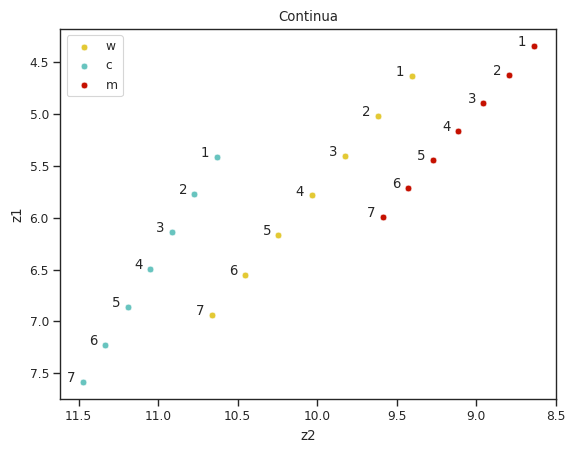

In [13]:
labix = 0
for d in datalist:
    # get the name of the dataset
    lab = labellist[labix]
    pl = sns.scatterplot(x = 'z2', y = 'z1', data = d, label = lab)
    # Label points
    for line, row in d.iterrows():
        pl.text(d['z2'][line]+0.1, d['z1'][line], d['step'][line])
    labix += 1
pl.invert_yaxis()
pl.invert_xaxis()
plt.title("Continua")
plt.show()